# Using the Pangeo STAC catalog from Julia

In this example we will access STAC catalog from within the Pangeo Cloud (on the Google Cloud) and load the Zarr data from the object storage.

First you will need to install Julia (e.g. in `/home/jovyan/opt/julia-x.y.z`) and the `IJulia` package on the pangeo cloud. This can be done using the notebook `Install-Julia-on-pangeo.ipynb`.

If necessary install the following package by uncommenting the following line.

In [18]:
using Pkg
#Pkg.add(["CFTime","HTTP","JSON3","PyPlot",URIs"])
#Pkg.add(url="https://github.com/JuliaClimate/STAC.jl")

We use also the master version of Zarr.jl

In [3]:
#]add Zarr#master

In [4]:
using CFTime, HTTP, JSON3, PyPlot, Zarr, URIs
using STAC

Implement functions to get access token and user project from the metadata server and implemented the Google Cloud store for Zarr.jl (adapted from the S3 storage function).

In [19]:
import Zarr: AbstractStore, storageregexlist, storefromstring, ConsolidatedStore, subdirs, ZGroup
import Base: getindex, show

function request_headers(; metadata_url = "http://metadata.google.internal/computeMetadata/v1/")
    headers = Dict("Metadata-Flavor" => "Google")
    
    url = joinpath(metadata_url,"project","project-id")
    user_project = String(HTTP.get(url, headers=headers).body)

    url = joinpath(metadata_url,"instance","service-accounts","default","token")
    auth = JSON3.read(HTTP.get(url,headers).body);

    return Dict(
       "Authorization" => "$(auth[:token_type]) $(auth[:access_token])",
       "x-goog-user-project" => user_project,
    );
end  

struct GCStore <: AbstractStore
    url::String
    headers::Dict{String,String}
end

GCStore(url::String) = GCStore(url,request_headers())

# do not show headers
Base.show(io::IO, s::GCStore) = print(io, "GCStore($(s.url))")


function Base.getindex(s::GCStore, k::String)
    r = HTTP.request("GET",string(s.url,"/",k),s.headers,status_exception = false)
    if r.status >= 300
        if r.status == 404
            nothing
        else
            error("Error connecting to $(s.url) :", String(r.body))
        end
    else
        r.body
    end
end

function list_objects(bucket,params,headers)
    base_URL = "https://storage.googleapis.com/storage/v1/b/"
    r = JSON3.read(HTTP.get(base_URL * bucket * "/o",headers,
        query = params).body)    
end

function cloud_list_objects(s::GCStore,path)
    bucket = lstrip(URI(s.url).path,'/')
    prefix = (isempty(path) || endswith(path,"/")) ? path : string(path,"/")
    return list_objects(bucket, Dict("prefix" => prefix, "delimiter" => "/"),s.headers)
end

function subkeys(s::GCStore, path)
    r = cloud_list_objects(s, path)
    keys = map(item -> String(split(item[:name],'/')[end]),  r[:items])
    return keys
end


function subdirs(s::GCStore, path)  
    r = cloud_list_objects(s,path)   
    dirs = map(prefix -> String(split(prefix,'/')[end-1]), r[:prefixes])
    return dirs
end


pushfirst!(storageregexlist,r"^https://storage.googleapis.com"=>GCStore)
pushfirst!(storageregexlist,r"^http://storage.googleapis.com"=>GCStore)
storefromstring(::Type{<:GCStore}, s,_) = GCStore(s),""

#=
MethodError: no method matching ZGroup(::GCStore, ::SubString{String}, ::Dict{String, ZArray}, ::Dict{String, ZGroup}, ::Dict{String, Any}, ::Bool)
Closest candidates are:
  ZGroup(::S, ::String, ::Dict{String, ZArray}, ::Dict{String, ZGroup}, ::Dict, ::Bool) where S<:AbstractStore at /home/jovyan/.julia/dev/Zarr/src/ZGroup.jl:2
  ZGroup(::T, ::Any, ::Any) where T<:AbstractStore at /home/jovyan/.julia/dev/Zarr/src/ZGroup.jl:13
  ZGroup(::T, ::Any) where T<:AbstractStore at /home/jovyan/.julia/dev/Zarr/src/ZGroup.jl:13
=#

ZGroup(storage, path::AbstractString, arrays, groups, attrs, writeable) = ZGroup(storage, String(path), arrays, groups, attrs, writeable)

ZGroup

In [20]:
# Test with:

ss = GCStore("https://storage.googleapis.com/pangeo-cmems-duacs");
@show subdirs(ss,"")
@show subkeys(ss,"")

@show subdirs(ss,"sea_surface_height_clg")
@show subkeys(ss,"sea_surface_height_clg")


subdirs(ss, "") = ["adt", "crs", "err", "lat_bnds", "latitude", "lon_bnds", "longitude", "nv", "sea_surface_height_clg", "sla", "time", "ugos", "ugosa", "vgos", "vgosa"]
subkeys(ss, "") = [".zattrs", ".zgroup", ".zmetadata"]
subdirs(ss, "sea_surface_height_clg") = ["adt", "crs", "err", "lat_bnds", "latitude", "lon_bnds", "longitude", "nv", "sla", "time", "ugos", "ugosa", "vgos", "vgosa"]
subkeys(ss, "sea_surface_height_clg") = [".zattrs", ".zgroup", ".zmetadata"]


3-element Vector{String}:
 ".zattrs"
 ".zgroup"
 ".zmetadata"

Open the STAC catalog

In [7]:
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore-stac/master/master/catalog.json"

catalog = STAC.Catalog(url)

master
Pangeo Master Data Catalog

Children:
   * ocean
   * atmosphere
   * climate
   * hydro


Choose ocean -> sea_surface_height

In [8]:
cat2 = catalog["ocean"]["sea_surface_height"]

sea_surface_height
sea-surface altimetry data from The Copernicus Marine Environment

Assets:
   * zmetadata


In [9]:
cat2.assets["zmetadata"]

Consolidated metadata file for Zarr store
type: application/json
href: https://storage.googleapis.com/pangeo-cmems-duacs/.zmetadata


Get the URL of the assets 

In [10]:
url = href(cat2.assets["zmetadata"])

"https://storage.googleapis.com/pangeo-cmems-duacs/.zmetadata"

In [11]:
url2 = replace(url,"/.zmetadata" => "")

"https://storage.googleapis.com/pangeo-cmems-duacs"

In [12]:
zds = zopen(url2)

ZarrGroup at GCStore(https://storage.googleapis.com/pangeo-cmems-duacs) and path 
Variables: time lon_bnds ugos vgosa sla vgos adt nv crs err latitude ugosa longitude lat_bnds 
Groups: sea_surface_height_clg 

Plot the last time instance

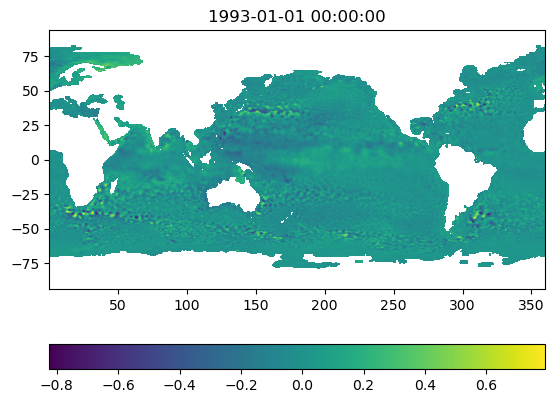

In [17]:
data = zds["sla"][:,:,1];
time = CFTime.timedecode(zds["time"][:],zds["time"].attrs["units"],get(zds["time"].attrs,"calendar","standard"));

lon = zds["longitude"][:]
lat = zds["latitude"][:]

pcolormesh(lon,lat,coalesce.(data,NaN)'); 
PyPlot.title(time[1])
colorbar(orientation="horizontal"); 
axis("equal");

Used version in this notebook

In [14]:
]status --manifest

      Status `~/.julia/environments/v1.6/Manifest.toml`
  [fbe9abb3] AWS v1.61.0
  [79e6a3ab] Adapt v3.3.1
  [a74b3585] Blosc v0.7.1
  [179af706] CFTime v0.1.1
  [944b1d66] CodecZlib v0.7.0
  [3da002f7] ColorTypes v0.11.0
  [5ae59095] Colors v0.12.8
  [34da2185] Compat v3.40.0
  [8f4d0f93] Conda v1.5.2
  [864edb3b] DataStructures v0.18.10
  [3c3547ce] DiskArrays v0.2.12
  [e2ba6199] ExprTools v0.1.6
  [8f5d6c58] EzXML v1.1.0
  [53c48c17] FixedPointNumbers v0.8.4
  [cf35fbd7] GeoInterface v0.5.6
  [61d90e0f] GeoJSON v0.5.1
  [bc5e4493] GitHub v5.7.0
  [cd3eb016] HTTP v0.9.16
  [7073ff75] IJulia v1.23.2
  [83e8ac13] IniFile v0.5.0
  [c8e1da08] IterTools v1.3.0
  [692b3bcd] JLLWrappers v1.3.0
  [682c06a0] JSON v0.21.2
  [0f8b85d8] JSON3 v1.9.2
  [8ac3fa9e] LRUCache v1.3.0
  [b964fa9f] LaTeXStrings v1.2.1
  [1914dd2f] MacroTools v0.5.9
  [739be429] MbedTLS v1.0.3
  [78c3b35d] Mocking v0.7.3
  [6fe1bfb0] OffsetArrays v1.10.7
  [bac558e1] OrderedCollections v1.4.1
  [69de0a69] Parsers v2.1.2

In [15]:
versioninfo()

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
